# Coursework 2: Image Classification

In this coursework, we are going to develop a neural network model for for image classification.

What to do?

* The coursework includes both coding questions and written questions. Please read both the text and code comment in this notebook to get an idea what you are supposed to implement.

* First, run `jupyter-lab` or `jupyter-notebook` in the terminal to start the Jupyter notebook.

* Then, complete and run the code to get the results.

* Finally, please export (File | Export Notebook As...) or print (using the print function of your browser) the notebook as a pdf file, which contains your code, results and answers, and upload the pdf file onto Cate.

Dependencies:

* If you work on a college computer in the Computer Lab, where Ubuntu 18.04 is installed by default, you can use the following virtual environment for your work, where required Python packages are already installed.

`source /vol/bitbucket/wbai/virt/computer_vision_2020/bin/activate`

When you no longer need the virtual environment, you can exit it by running `deactivate`.

* If you work on your own laptop using either Anaconda or plain Python, you can install new packages (such as numpy, imageio etc) running `conda install [package_name]` or `pip3 install [package_name]` in the terminal.

In [1]:
# Import libraries (provided)
import math
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# 1. Load and visualise data. (25 marks)

Throughout this coursework. you will be working with the Fashion-MNIST dataset. If you are interested, you may find information about the dataset in this paper.

[1] Han Xiao, Kashif Rasul, Roland Vollgraf. Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The dataset is prepared in a similar way to MNIST. It is split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels.

There are in total 10 label classes, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

In [2]:
# Load data (provided)
train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)

### 1.1 Display the dimension of the training and test sets. (5 marks)

### ---------- ????? SHOULD THIS BE JUST 6000???

In [3]:
train_set_len = train_set.data.size()[0]
test_set_len = test_set.data.size()[0]
print(train_set.data.size()[0])
print(test_set.data.size()[0])


60000
10000


### 1.2 Visualise sample images for each of the 10 classes. (10 marks)

Please plot 10 rows x 10 columns of images. Each row shows 10 samples for one class. For example, row 1 shows 10 `T-shirt/top` images, row 2 shows 10 `Trousers` images.

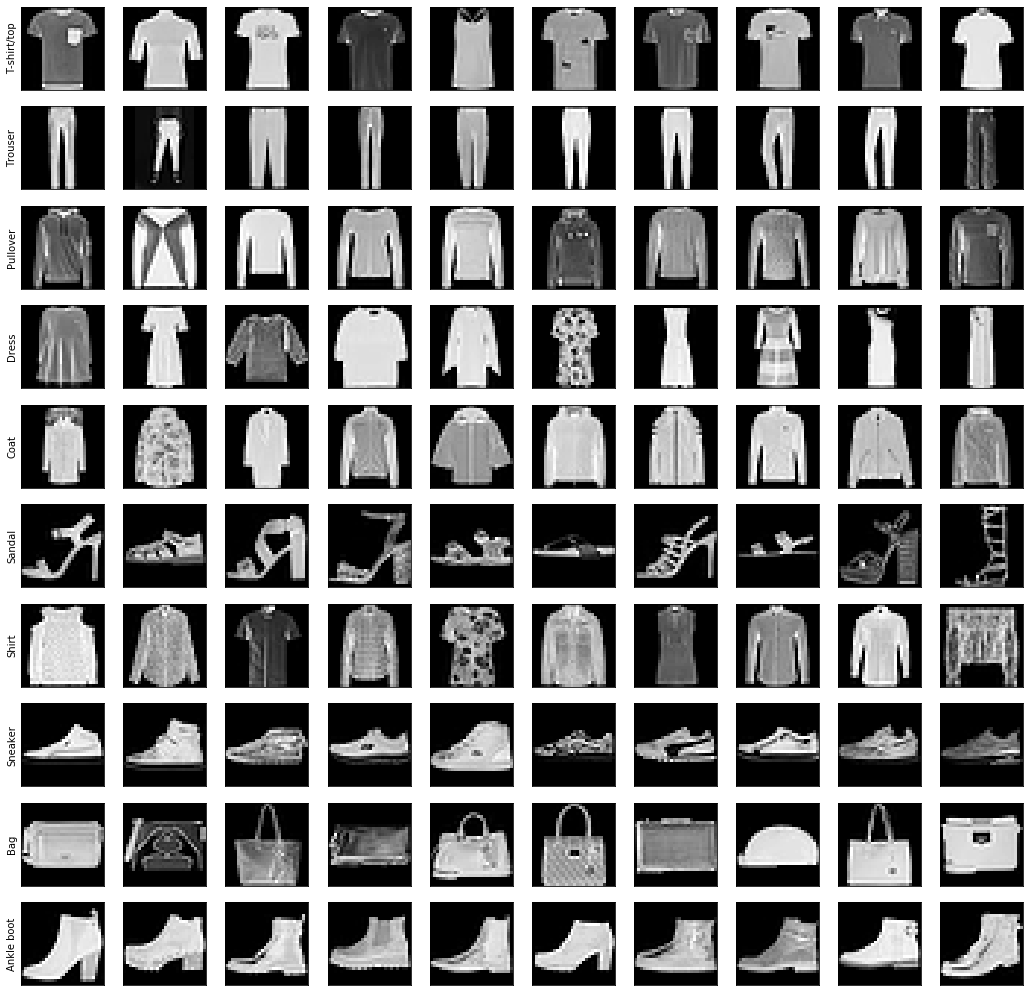

In [4]:
num_subplots = 10
# fig, ax = plt.subplots(nrows=num_subplots, ncols=num_subplots, figsize=(12, 12))

fig, axs = plt.subplots(10, 10, figsize=(18,18))
#axs.setp(axes, xticks=[], yticks=[])
for i in range(10):
    j = 0
    while j < 10:
        r = random.randint(0,train_set_len)
        if(train_label[r]==i):
            axs[i,j].imshow(train_image[r], cmap='gray')
            axs[i,j].set_yticklabels([])
            axs[i,j].set_xticklabels([])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            j+=1
    
    axs[i,0].set(ylabel=class_name[i])

### 1.3 Display the number of training samples for each class. (5 marks)

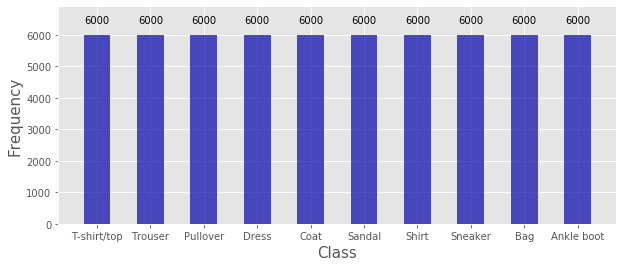

In [5]:
#get unique labels and their counts
labels, counts = np.unique(train_label, return_counts=True)

# graphical display of the number of training samples in each class
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Class", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
ax.set_ylim(0,np.max(counts)+np.max(counts)*0.15)
rects = ax.bar(class_name, counts, align='center', width=0.5, color='#0504aa', alpha=0.7)

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%d' % int(height),ha='center', va='bottom')

plt.show()

### 1.4 Discussion. (5 marks)
Is the dataset balanced? What would happen for the image classification task if the dataset is not balanced? 

The dataset is perfectly balanced ... ??????????????

## 2. Image classification. (60 marks)

### 2.1 Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset. (15 marks)

You can use a network architecture similar to LeNet (shown below), which consists a number of convolutional layers and a few fully connected layers at the end.

![](lenet.png)

In [6]:
from collections import OrderedDict
class LeNet5(nn.Module):
    def __init__(self):
#         super(LeNet5, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.drop_out = nn.Dropout()
#         self.fc1 = nn.Linear(7 * 7 * 64, 1000)
#         self.fc2 = nn.Linear(1000, 10)
        
        super(LeNet5, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
            
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
            
        self.drop_out = nn.Dropout() # what is this for?
        self.fc1 = nn.Sequential(
            nn.Linear(16*5*5,120),
            #nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(120,84),
            #nn.ReLU()
        )
        
        self.fc3 = nn.Linear(84,10)
#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.drop_out(out)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         return out
        
    def forward(self, img):
        out = self.layer1(img)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        # CrossEntropyLoss function combines 
        # SoftMax activation and cross entropy
        return out

### 2.2 Define the loss function, optimiser and hyper-parameters such as the learning rate, number of iterations, batch size etc. (5 marks)

In [7]:
# Batch Size
batch_size = 100

# Learning Rate
learning_rate = 0.001

# Number of iterations
num_epochs = 2

# Total length of the dataset
n = len(train_image)

#Loss function
criterion = nn.CrossEntropyLoss()

model = LeNet5()

#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 2.3 Start model training. (20 marks)

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent. Please also evaluate how long it takes for training.

In [8]:
#data_shuffled = train_image[indices].astype(np.float32)
#tensor_data = torch.from_numpy(data_batch)[:, None, :, :]
#np.random.permutation


loss_list = []
acc_list = []
nr_batches = math.ceil(n / batch_size)


for epoch in range(num_epochs):
    indices = np.random.permutation(n)
    img_shuffled = train_image[indices].astype(np.float32)
    lab_shuffled = train_label[indices]
           
    img_batches = np.array_split(img_shuffled, nr_batches)
    lab_batches = np.array_split(lab_shuffled, nr_batches)

    
    for i, (img_batch, lab_batch) in enumerate(zip(img_batches, lab_batches)):
        images = torch.from_numpy(img_batch)[:, None, :, :]
        labels = torch.from_numpy(lab_batch)
        
        #run forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # backprop and perform Adam optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct/total)
        
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, (i+1)*batch_size, n, loss.item(),
                          (correct / total) * 100))
        

Epoch [1/2], Step [10000/60000], Loss: 0.6153, Accuracy: 77.00%
Epoch [1/2], Step [20000/60000], Loss: 0.6065, Accuracy: 80.00%
Epoch [1/2], Step [30000/60000], Loss: 0.4101, Accuracy: 83.00%
Epoch [1/2], Step [40000/60000], Loss: 0.5669, Accuracy: 79.00%
Epoch [1/2], Step [50000/60000], Loss: 0.5136, Accuracy: 81.00%
Epoch [1/2], Step [60000/60000], Loss: 0.7294, Accuracy: 76.00%
Epoch [2/2], Step [10000/60000], Loss: 0.5380, Accuracy: 80.00%
Epoch [2/2], Step [20000/60000], Loss: 0.4569, Accuracy: 85.00%
Epoch [2/2], Step [30000/60000], Loss: 0.4140, Accuracy: 85.00%
Epoch [2/2], Step [40000/60000], Loss: 0.4722, Accuracy: 79.00%
Epoch [2/2], Step [50000/60000], Loss: 0.6805, Accuracy: 79.00%
Epoch [2/2], Step [60000/60000], Loss: 0.4561, Accuracy: 85.00%


### 2.4 Deploy the trained model onto the test set. (10 marks)
Please also evaluate how long it takes for testing.

In [9]:
model.eval()
n = test_image.shape[0]
nr_batches = math.ceil(n / batch_size)

with torch.no_grad():
    correct=0
    total=0
    
    img = test_image.astype(np.float32)
    lab = test_label

    img_batches = np.array_split(img, 1)
    lab_batches = np.array_split(lab, 1)

    
    for img_batch, lab_batch in zip(img_batches, lab_batches):
        images = torch.from_numpy(np.array(img_batch))[:, None, :, :]
        labels = torch.from_numpy(lab_batch)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

### 2.5 Evaluate the classification accuracy on the test set. (5 marks)

In [10]:
print("Accuracy: ", metrics.accuracy_score(labels, predicted))

Accuracy:  0.8537


### 2.6 Print out and visualise the confusion matrix. (5 marks)
You can use relevant functions in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

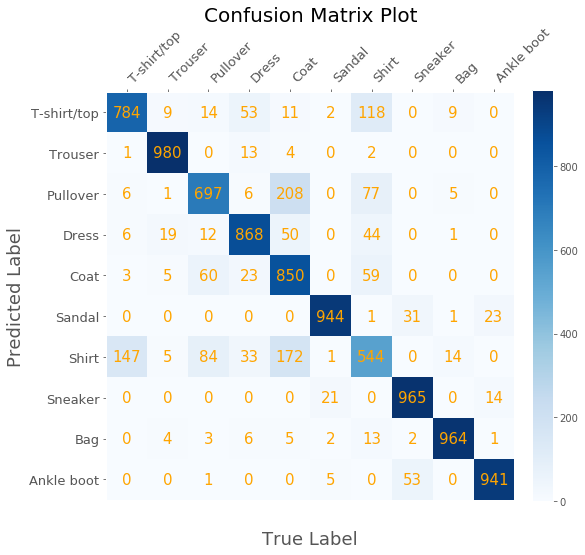

In [11]:
cm = metrics.confusion_matrix(labels, predicted)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap=plt.cm.Blues)
fig.colorbar(cax, fraction=0.046, pad=0.04) 
ax.grid(False)

#annotate with exact numbers in boxes
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.annotate(cm[i,j],xy=(j,i),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=15,color='orange')

plt.title("Confusion Matrix Plot", pad = 50, fontdict={'fontsize': 20})

# plt.xticks(range(len(class_name)), class_name, rotation=45)
# plt.yticks(range(len(class_name)), class_name)

# want a more natural, table-like display
# ax.invert_yaxis()
# ax.invert_yaxis()

ax.xaxis.tick_top()

ax.tick_params(axis='both', labelsize=13)
ax.set_yticks(range(len(class_name)),minor=False)
ax.set_xticks(range(len(class_name)), minor=False)
ax.set_xticklabels(class_name, minor=False, rotation=45, ha='left')
ax.set_yticklabels(class_name, minor=False)
#ax.xaxis.set_ticks_position('bottom')

plt.xlabel('True Label', fontsize=18, labelpad=30)
plt.ylabel('Predicted Label', fontsize=18)
ax.set_ylim(10-0.5, -0.5)

plt.rcParams["axes.edgecolor"] = "0.6"
plt.rcParams["axes.grid"] = False
plt.show()

## 3. Deploy in real world. (15 marks)

Take 3 photos that belongs to the 10 classes (e.g. clothes, shoes) in your real life. Use either Python or other software (Photoshop, Gimp etc) to convert the photos into grayscale, negate the intensities so that background becomes black or dark, crop the region of interest and reshape into the size of 28x28.

### 3.1 Load and visualise your own images (5 marks)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


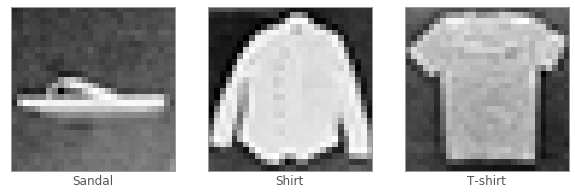

In [12]:
personal_dataset = torchvision.datasets.ImageFolder(root='.', transform=transforms.ToTensor())

pers_images = [torchvision.transforms.ToPILImage()(x[0]) for x in personal_dataset]
pers_images = [torchvision.transforms.Grayscale()(x) for x in pers_images]
pers_images = [torchvision.transforms.ToTensor()(x) for x in pers_images]
pers_images = [np.squeeze(np.array(x)) for x in pers_images]


pers_labels = np.array([5, 6, 0])
print(type(pers_labels))
pers_lab_names = ["Sandal", "Shirt", "T-shirt"]

fig, axs = plt.subplots(1, 3, figsize=(10,30))

np_images = []
for i in range(3):
    axs[i].imshow(pers_images[i], cmap='gray')
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
    axs[i].set(xlabel=pers_lab_names[i])
print(type(pers_labels))

### 3.2 Test your network on the real images and display the classification results. (5 marks)

In [13]:
print(images[0].shape)
print(type(pers_labels))
print(pers_labels.shape)
print(pers_labels)

model.eval()
with torch.no_grad():
    pers_correct=0
    pers_total=0
    
    pers_images = np.array(pers_images).astype(np.float32)
    
    pers_images = torch.from_numpy(pers_images)[:, None, :, :]
    print(type(pers_labels))
    pers_labels = torch.from_numpy(pers_labels)

    pers_outputs = model(pers_images)
    _, pers_predicted = torch.max(pers_outputs.data,1)
    pers_total += pers_labels.size(0)
    pers_correct += (pers_predicted == pers_labels).sum().item()

print(pers_labels)
print(pers_predicted)
print("Accuracy: ", metrics.accuracy_score(pers_labels, pers_predicted))

torch.Size([1, 28, 28])
<class 'numpy.ndarray'>
(3,)
[5 6 0]
<class 'numpy.ndarray'>
tensor([5, 6, 0])
tensor([6, 6, 6])
Accuracy:  0.3333333333333333


### 3.3 Discuss the classification results. (5 marks)

Does the model work? Is there anyway to improve the real life performance of the model?